In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import geopandas as gpd
import folium
import openrouteservice as ors
from folium import plugins

In [272]:
ciudades = [
    'Chilpancingo, Guerrero',
    'Cuernavaca, Morelos',
    'Ciudad de México, Ciudad de México',
    'Pachuca, Hidalgo',
    'Puebla, Puebla',
    'Tlaxcala, Tlaxcala',
    'Morelia, Michoacán',
    'Querétaro, Querétaro',
    'San Luis Potosí, San Luis Potosí',
    'Guanajuato, Guanajuato',
    'Aguascalientes, Aguascalientes',
    'Zacatecas, Zacatecas',
    'Durango, Durango',
    'Culiacán, Sinaloa',
    'Hermosillo, Sonora',
    'Mexicali, Baja California',
    'La Paz, Baja California Sur',
    'Colima, Colima',
    'Guadalajara, Jalisco',
    'Tepic, Nayarit',
    'Chihuahua, Chihuahua',
    'Monterrey, Nuevo León',
    'Ciudad Victoria, Tamaulipas',
    'Saltillo, Coahuila',
    'Oaxaca de Juárez, Oaxaca',
    'Xalapa, Veracruz',
    'Villahermosa, Tabasco',
    'Campeche, Campeche',
    'Mérida, Yucatán',
    'Chetumal, Quintana Roo',
    'Tuxtla Gutiérrez, Chiapas',
    'Toluca, Estado de México'
]


In [273]:
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

In [274]:
np.random.seed(42)

In [275]:
COSTO_COMBUSTIBLE = 23.96
RENDIMIENTO_AUTO = 20.69
VALOR_HORA = 35

In [276]:
distancias = pd.read_csv("tabla_distancias.csv", index_col=0)  # Tabla de distancias (km)
tiempos = pd.read_csv("tabla_tiempos.csv", index_col=0)        # Tabla de tiempos (horas)
peajes = pd.read_csv("peajes.csv", index_col=0)  # Tabla de costos de peajes (MXN)

In [277]:
def convertir_a_minutos(tiempo):
    if pd.isna(tiempo):
        return np.nan
    horas, minutos = map(int, str(tiempo).split(':'))
    return horas * 60 + minutos

tiempos_minutos = tiempos.map(convertir_a_minutos)

print("Tiempos convertidos a minutos satisfactoriamente.")

Tiempos convertidos a minutos satisfactoriamente.


In [278]:
num_ciudades = distancias.shape[0]
costos = np.zeros((num_ciudades, num_ciudades))

for i in range(num_ciudades):
    for j in range(num_ciudades):
        if i != j:  # Evitar costos para una ciudad hacia sí misma
            distancia = distancias.iloc[i, j]
            tiempo = tiempos_minutos.iloc[i, j] / 60
            peaje = peajes.iloc[i, j]

            costo_combustible = (distancia / RENDIMIENTO_AUTO) * COSTO_COMBUSTIBLE
            costo_tiempo = tiempo * VALOR_HORA

            costos[i, j] = costo_combustible + costo_tiempo + peaje

matriz_costos = pd.DataFrame(costos, index=distancias.index, columns=distancias.columns)

matriz_costos.to_excel("matriz_costos.xlsx")

print("Matriz de costos calculada y guardada en 'matriz_costos.xlsx'")

Matriz de costos calculada y guardada en 'matriz_costos.xlsx'


In [279]:
matriz_costos = pd.read_excel("matriz_costos.xlsx", index_col=0)
ciudades = matriz_costos.index

In [280]:
NUM_HORMIGAS = 32
ALFA = 1  
BETA = 2  
EVAPORACION = 0.5
ITERACIONES = 500
Q = 100 

In [281]:
num_ciudades = len(ciudades)
feromonas = np.ones((num_ciudades, num_ciudades))
mejor_ruta = None
mejor_costo = float("inf")

In [282]:
def calcular_probabilidades(actual, visitados):
    """
    Calcular las probabilidades de ir de la ciudad actual a las no visitadas.
    """
    heuristica = 1.0 / (matriz_costos.values[actual] + 1e-10)  # Inverso del costo
    heuristica[visitados] = 0  # Las ciudades visitadas no son elegibles
    feromonas_actual = feromonas[actual]

    # Calcular probabilidades basadas en feromonas y heurística
    numeradores = (feromonas_actual ** ALFA) * (heuristica ** BETA)
    suma = np.sum(numeradores)
    if suma == 0:
        return np.zeros_like(numeradores)
    return numeradores / suma


def construir_ruta():
    """
    Construir una ruta para una hormiga utilizando las probabilidades.
    """
    ruta = [np.random.randint(num_ciudades)]
    while len(ruta) < num_ciudades:
        actual = ruta[-1]
        probabilidades = calcular_probabilidades(actual, ruta)
        siguiente = np.random.choice(range(num_ciudades), p=probabilidades)
        ruta.append(siguiente)

    return ruta


def calcular_costo(ruta):
    """
    Calcular el costo total de una ruta.
    """
    costo = 0
    for i in range(len(ruta) - 1):
        costo += matriz_costos.iloc[ruta[i], ruta[i + 1]]
    costo += matriz_costos.iloc[ruta[-1], ruta[0]]  # Volver al inicio
    return costo


def actualizar_feromonas(solutions):
    """
    Actualizar las feromonas basado en las soluciones encontradas.
    """
    global feromonas
    # Evaporar feromonas
    feromonas *= (1 - EVAPORACION)

    # Depositar nuevas feromonas
    for ruta, costo in solutions:
        for i in range(len(ruta) - 1):
            feromonas[ruta[i], ruta[i + 1]] += Q / costo
        feromonas[ruta[-1], ruta[0]] += Q / costo

In [283]:
np.random.seed(42)

historial_costos = []
historial_mejor_costo = []

for _ in range(ITERACIONES):
    soluciones = []
    costos_iteracion = []
    for _ in range(NUM_HORMIGAS):
        ruta = construir_ruta()
        costo = calcular_costo(ruta)
        soluciones.append((ruta, costo))
        costos_iteracion.append(costo)
        
        if costo < mejor_costo:
            mejor_ruta, mejor_costo = ruta, costo
    
    historial_costos.append(costos_iteracion)
    historial_mejor_costo.append(mejor_costo)

    actualizar_feromonas(soluciones)

mejor_ruta_ciudades = [ciudades[i] for i in mejor_ruta]
print("Mejor ruta encontrada:", mejor_ruta_ciudades)
print("Costo total:", mejor_costo)

Mejor ruta encontrada: ['Guanajuato', 'Santiago de Querétaro', 'Toluca de Lerdo', 'CDMX', 'Cuernavaca', 'Chilpancingo de los Bravo', 'Tlaxcala de Xicohténcatl', 'Heroica Puebla de Zaragoza', 'Oaxaca de Juárez', 'Tuxtla Gutiérrez', 'Villahermosa', 'San Francisco de Campeche', 'Mérida', 'Chetumal', 'Xalapa-Enríquez', 'Pachuca de Soto', 'Morelia', 'Guadalajara', 'Colima', 'Tepic', 'Culiacán Rosales', 'La Paz', 'Hermosillo', 'Mexicali', 'Chihuahua', 'Victoria de Durango', 'Zacatecas', 'Aguascalientes', 'Saltillo', 'Monterrey', 'Ciudad Victoria', 'San Luis Potosí']
Costo total: 32114.72308200419


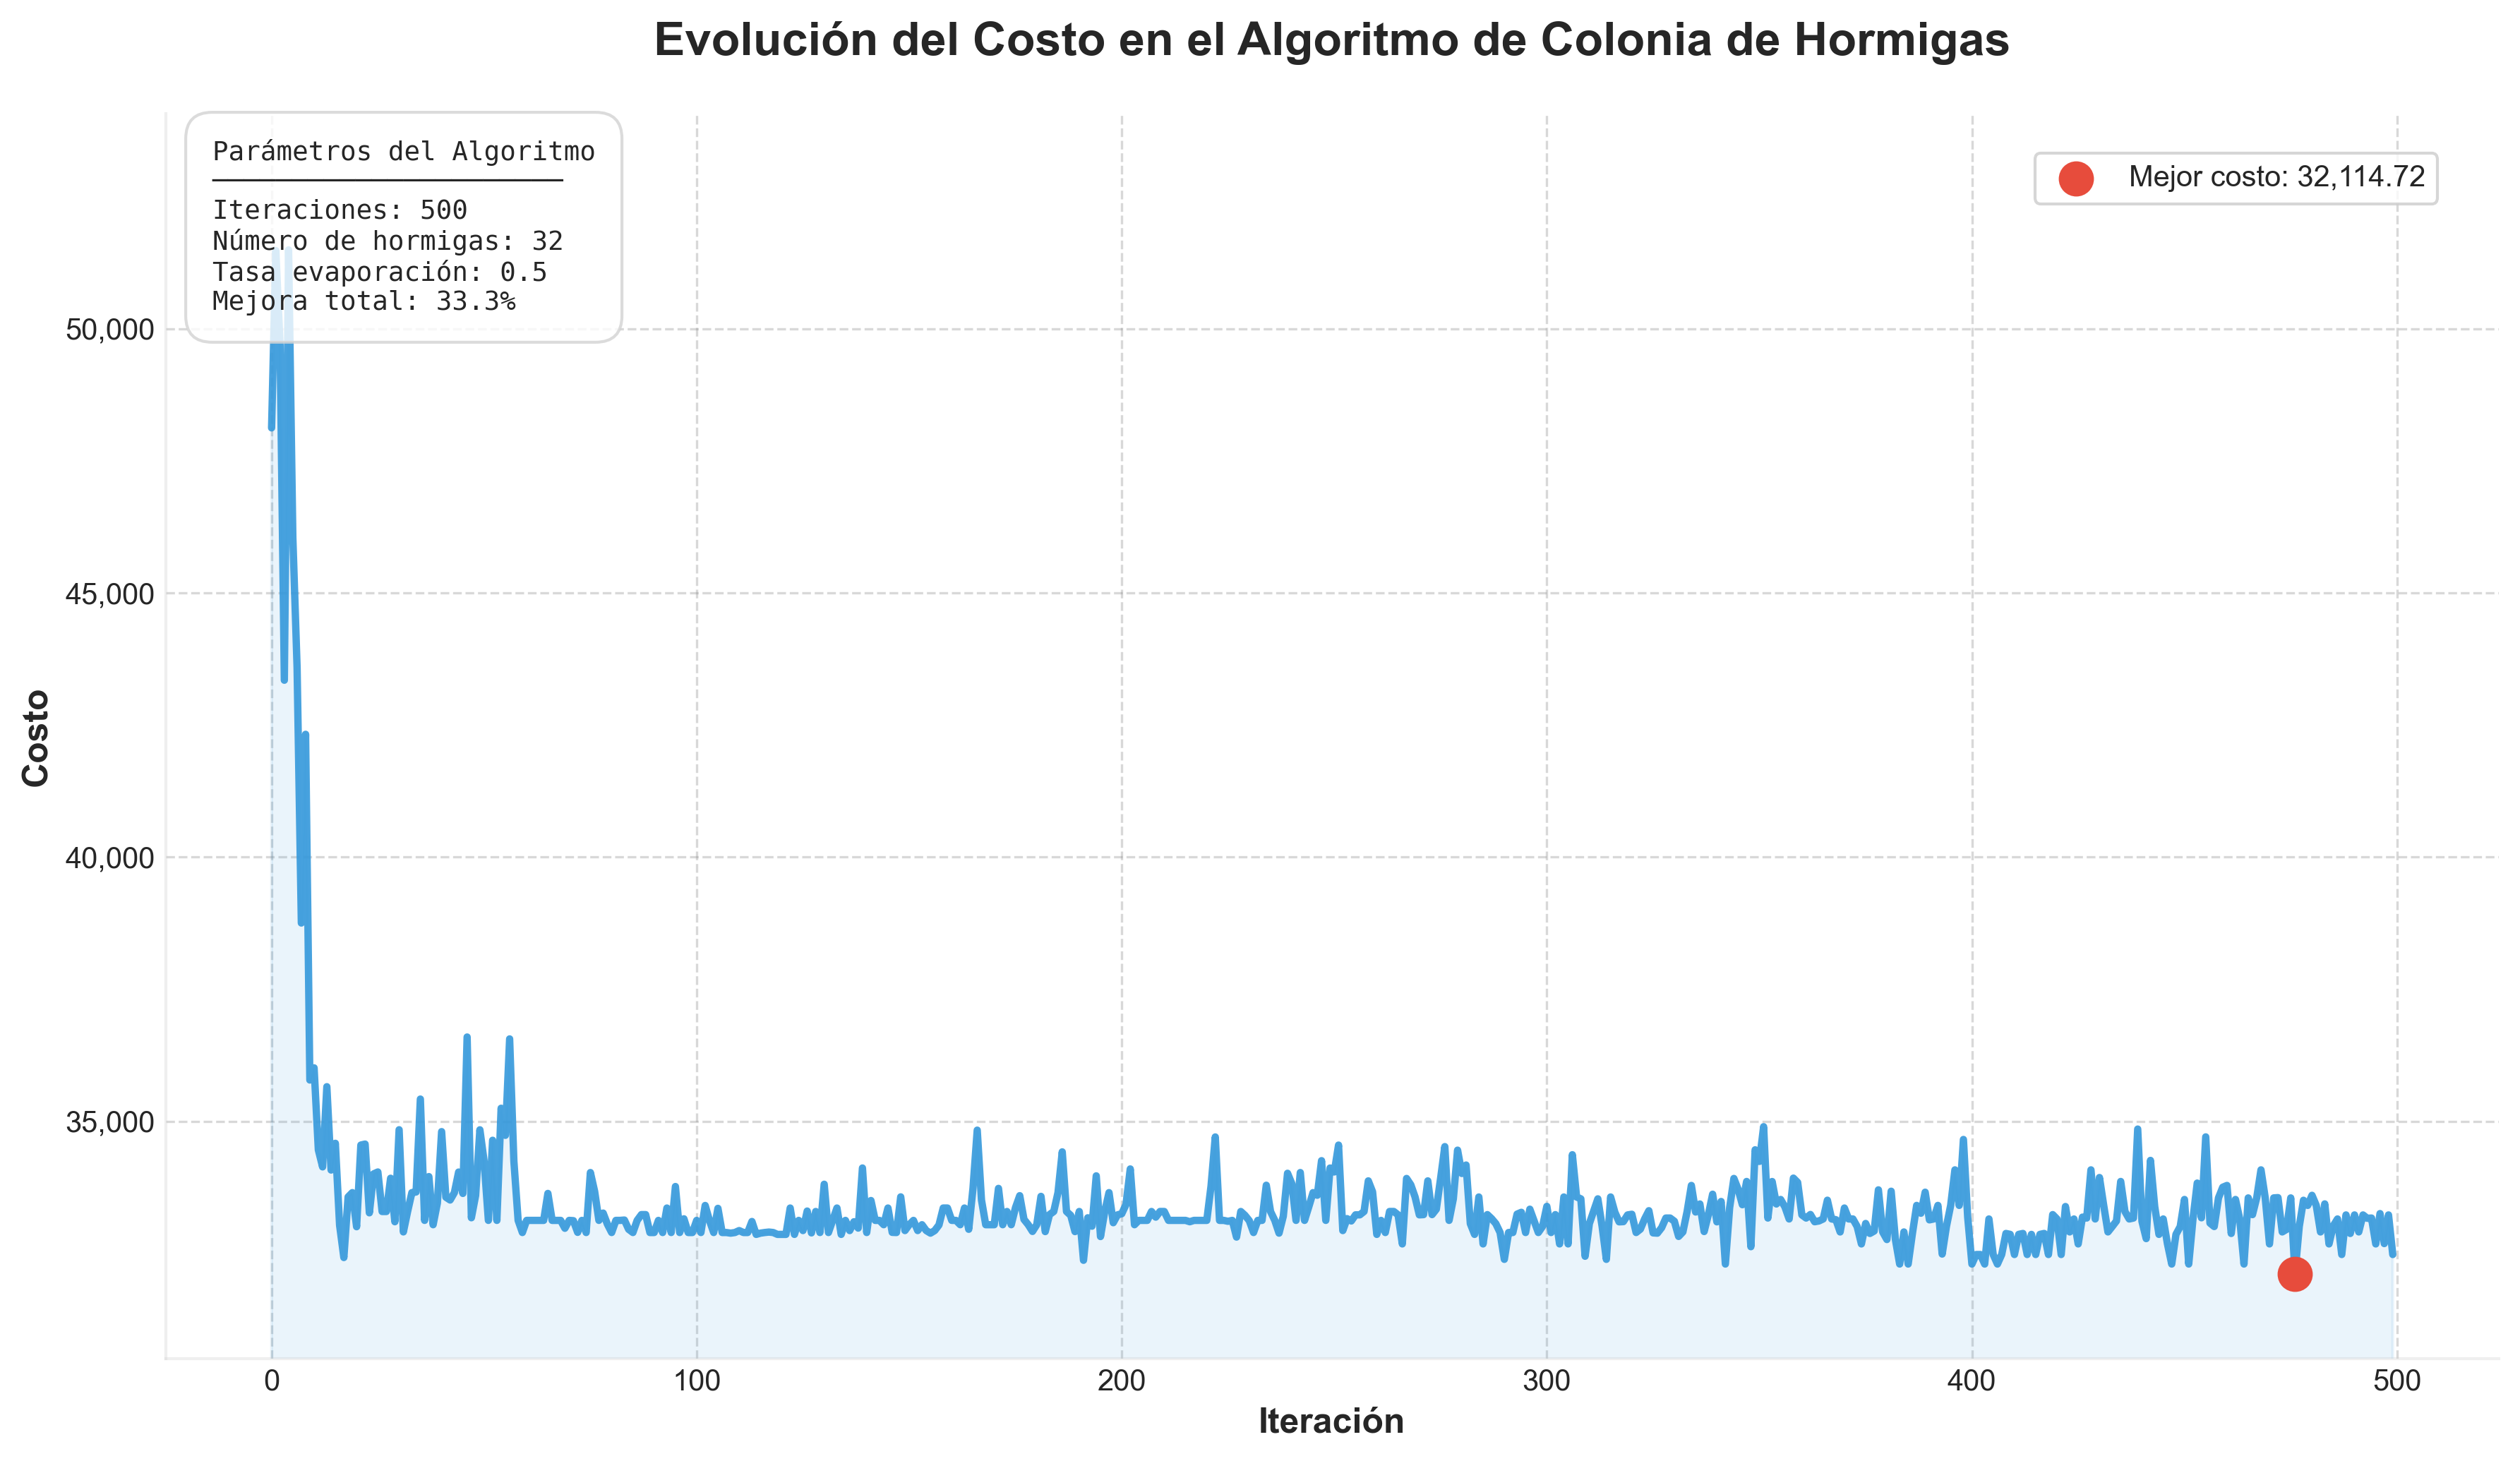

In [284]:
import matplotlib.pyplot as plt
import numpy as np

def plot_aco_evolution(historial_costos, mejor_costo, iteraciones, num_hormigas, tasa_evaporacion):
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear figura con fondo blanco
    fig, ax = plt.subplots(figsize=(12, 7), dpi=300, facecolor='white')
    ax.set_facecolor('white')
    
    # Procesar datos para la gráfica
    # Ahora usamos el mejor costo de cada iteración en lugar del promedio
    mejores_costos_iter = [min(costos) for costos in historial_costos]
    iterations = np.arange(len(mejores_costos_iter))
    
    # Crear el gráfico principal
    main_color = '#3498db'
    ax.plot(iterations, mejores_costos_iter, 
            color=main_color, 
            linewidth=2.5,
            alpha=0.9)
    
    # Añadir área sombreada bajo la curva
    ax.fill_between(iterations, 
                   mejores_costos_iter, 
                   color=main_color, 
                   alpha=0.1)
    
    # Encontrar la iteración donde se encontró el mejor costo
    idx_mejor_costo = mejores_costos_iter.index(mejor_costo)
    
    # Marcar el mejor costo
    ax.scatter(idx_mejor_costo, 
              mejor_costo,
              color='#e74c3c', 
              s=120, 
              zorder=5,
              label=f'Mejor costo: {mejor_costo:,.2f}')
    
    # Personalizar el grid
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Configurar los ejes
    ax.set_xlabel('Iteración', fontsize=12, fontweight='bold')
    ax.set_ylabel('Costo', fontsize=12, fontweight='bold')
    
    # Eliminar los bordes del gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.3)
    
    # Formatear los números del eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Ajustar los límites del eje Y
    ymin = min(mejores_costos_iter) * 0.95
    ymax = max(mejores_costos_iter) * 1.05
    ax.set_ylim(ymin, ymax)
    
    # Título principal
    plt.title('Evolución del Costo en el Algoritmo de Colonia de Hormigas', 
             fontsize=16, 
             fontweight='bold', 
             pad=20)
    
    # Crear cuadro de texto para los parámetros
    mejora_total = ((mejores_costos_iter[0] - mejor_costo) / mejores_costos_iter[0] * 100)
    param_text = (
        'Parámetros del Algoritmo\n'
        '──────────────────────\n'
        f'Iteraciones: {iteraciones}\n'
        f'Número de hormigas: {num_hormigas}\n'
        f'Tasa evaporación: {tasa_evaporacion}\n'
        f'Mejora total: {mejora_total:.1f}%'
    )
    
    # Añadir el cuadro de texto
    plt.text(0.02, 0.98, param_text,
             transform=ax.transAxes,
             fontsize=9,
             fontfamily='monospace',
             bbox=dict(facecolor='white',
                      edgecolor='lightgray',
                      alpha=0.8,
                      pad=10,
                      boxstyle='round,pad=1'),
             verticalalignment='top')
    
    # Leyenda
    legend = ax.legend(frameon=True,
                      framealpha=0.9,
                      fontsize=10,
                      loc='upper right',
                      bbox_to_anchor=(0.98, 0.98))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.8)
    
    # Ajustar los márgenes
    plt.tight_layout()
    
    # Guardar con alta calidad
    plt.savefig('evolucion_costos_aco.png',
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    
    plt.show()

# Para usar la función:
plot_aco_evolution(
    historial_costos,
    mejor_costo,
    ITERACIONES,
    NUM_HORMIGAS,
    EVAPORACION
)

In [285]:
def crear_mapa_ruta(mejor_ruta_ciudades, coordenadas):
    """
    Crea un mapa interactivo con la ruta optimizada entre ciudades.
    
    Args:
        mejor_ruta_ciudades (list): Lista de ciudades en orden de visita
        coordenadas (dict): Diccionario con las coordenadas de cada ciudad
    """
    # Crear un mapa centrado en México con estilo más limpio
    mapa = folium.Map(location=[23.6345, -102.5528], 
                     zoom_start=5,
                     tiles='cartodbpositron')
    
    # Crear una lista de coordenadas en el orden de la ruta
    coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta_ciudades]
    
    
    # Añadir marcadores para cada ciudad
    for i, ciudad in enumerate(mejor_ruta_ciudades):
        # Color especial para inicio y fin
        if i == 0:
            color = 'green'
            prefijo = 'Inicio: '
            icon = 'play'
        elif i == len(mejor_ruta_ciudades) - 1:
            color = 'red'
            prefijo = 'Fin: '
            icon = 'flag'
        else:
            color = 'blue'
            prefijo = f'Parada {i}: '
            icon = 'info-sign'
            
        folium.Marker(
            coordenadas[ciudad],
            popup=f"{prefijo}{ciudad}",
            tooltip=f"{i+1}. {ciudad}",
            icon=folium.Icon(color=color, icon=icon)
        ).add_to(mapa)
    
    # Dibujar las líneas entre las ciudades
    coordenadas_ruta.append(coordenadas_ruta[0])  # Conectar con el punto inicial
    folium.PolyLine(
        coordenadas_ruta,
        weight=2.5,
        color='#1E90FF',
        opacity=0.8,
        popup='Ruta optimizada'
    ).add_to(mapa)
    
    # Añadir una leyenda mejorada con información de distancia
    leyenda_html = f'''
        <div style="position: fixed; 
                    bottom: 50px; 
                    left: 50px; 
                    background-color: white; 
                    padding: 10px; 
                    border: 1px solid grey;
                    border-radius: 5px;
                    box-shadow: 3px 3px 3px rgba(0,0,0,0.2);
                    z-index: 1000;">
            <div style="font-size: 14px; font-weight: bold; margin-bottom: 10px;">
                Ruta Optimizada
            </div>
            <p><i class="fa fa-play" style="color:green"></i> Inicio</p>
            <p><i class="fa fa-info-sign" style="color:blue"></i> Paradas</p>
            <p><i class="fa fa-flag" style="color:red"></i> Fin</p>
        </div>
    '''
    mapa.get_root().html.add_child(folium.Element(leyenda_html))
    
    # Añadir elementos adicionales al mapa
    folium.LayerControl().add_to(mapa)
    plugins.MiniMap().add_to(mapa)
    plugins.MousePosition().add_to(mapa)
    
    # Guardar el mapa
    mapa.save('ruta_encontrada.html')
    print(f"\n💾 Mapa guardado como 'ruta_encontrada.html'")
    
    return mapa

mapa_ruta = crear_mapa_ruta(mejor_ruta_ciudades, coordenadas)


💾 Mapa guardado como 'ruta_encontrada.html'


In [286]:
import folium
from folium import plugins
import openrouteservice as ors
import time

def visualizar_ruta(mejor_ruta_ciudades):
    """
    Visualiza la ruta optimizada entre las ciudades usando OpenRouteService.
    
    Args:
        mejor_ruta_ciudades (list): Lista de nombres de ciudades en el orden optimizado
    """
    # Limpiar los nombres de las ciudades
    ciudades = [ciudad.strip() for ciudad in mejor_ruta_ciudades]
    
    # API key de OpenRouteService
    api_key = "5b3ce3597851110001cf6248c140bc578aac4c2d95295dc798e53a22"
    
    # Crear cliente de OpenRouteService
    client = ors.Client(key=api_key)
    
    # Geocodificar las ciudades para obtener coordenadas
    coordenadas = []
    for ciudad in ciudades:
        try:
            # Añadir ", México" para mejorar la precisión de la búsqueda
            geocode = client.pelias_search(text=f"{ciudad}, México")
            coords = geocode['features'][0]['geometry']['coordinates']
            coordenadas.append(coords)
            print(f"✓ Coordenadas encontradas para {ciudad}")
            # Añadir pequeña pausa para evitar límites de la API
            time.sleep(1)
        except Exception as e:
            print(f"✗ Error al geocodificar {ciudad}: {e}")
            continue
    
    # Crear mapa centrado en México
    mapa = folium.Map(location=[23.6345, -102.5528], 
                     zoom_start=5,
                     tiles='cartodbpositron')
    
    # Añadir marcadores para cada ciudad
    for i, coords in enumerate(coordenadas):
        # Color específico según la posición
        if i == 0:
            color = 'green'
            prefix = 'Inicio: '
            icon = 'play'
        elif i == len(coordenadas) - 1:
            color = 'red'
            prefix = 'Fin: '
            icon = 'flag'
        else:
            color = 'blue'
            prefix = f'Parada {i}: '
            icon = 'info-sign'
            
        folium.Marker(
            [coords[1], coords[0]],
            popup=prefix + ciudades[i],
            tooltip=f"{i+1}. {ciudades[i]}",
            icon=folium.Icon(color=color, icon=icon)  # Ahora usamos el icon específico definido
        ).add_to(mapa)
    
    # Obtener y dibujar la ruta entre ciudades consecutivas
    distancia_total = 0
    tiempo_total = 0
    
    # Añadir la última conexión al punto inicial para cerrar el ciclo
    coordenadas.append(coordenadas[0])
    ciudades.append(ciudades[0])
    
    for i in range(len(coordenadas)-1):
        try:
            # Obtener ruta entre par de ciudades
            ruta = client.directions(
                coordinates=[coordenadas[i], coordenadas[i+1]],
                profile='driving-car',
                format='geojson'
            )
            
            # Dibujar la ruta en el mapa
            folium.GeoJson(
                ruta,
                name=f'Ruta {i+1}: {ciudades[i]} - {ciudades[i+1]}',
                style_function=lambda x: {'color': '#1E90FF', 'weight': 2, 'opacity': 0.7}
            ).add_to(mapa)
            
            # Calcular y acumular estadísticas
            distancia = ruta['features'][0]['properties']['segments'][0]['distance']
            duracion = ruta['features'][0]['properties']['segments'][0]['duration']
            distancia_total += distancia
            tiempo_total += duracion
            
            print(f"\n📍 Ruta {i+1}: {ciudades[i]} → {ciudades[i+1]}:")
            print(f"   Distancia: {distancia/1000:.1f} km")
            print(f"   Tiempo estimado: {duracion/3600:.1f} horas")
            
            # Pequeña pausa para respetar límites de la API
            time.sleep(1)
            
        except Exception as e:
            print(f"✗ Error al obtener ruta entre {ciudades[i]} y {ciudades[i+1]}: {e}")
    
    # Imprimir resumen del viaje
    print(f"\n📊 Resumen del viaje:")
    print(f"   Distancia total: {distancia_total/1000:.1f} km")
    print(f"   Tiempo total estimado: {tiempo_total/3600:.1f} horas")
    
    # Añadir elementos adicionales al mapa
    folium.LayerControl().add_to(mapa)
    plugins.MiniMap().add_to(mapa)
    plugins.MousePosition().add_to(mapa)
    
    # Actualizar la leyenda con los iconos correctos
    leyenda_html = '''
        <div style="position: fixed; bottom: 50px; left: 50px; 
                    background-color: white; padding: 10px; border: 1px solid grey;
                    z-index: 1000;">
        <h4>Leyenda</h4>
            <p><i class="fa fa-play" style="color:green"></i> Inicio</p>
            <p><i class="fa fa-info-sign" style="color:blue"></i> Paradas</p>
            <p><i class="fa fa-flag" style="color:red"></i> Fin</p>
        Distancia total: {:.1f} km<br>
        Tiempo estimado: {:.1f} horas</p>
        </div>
    '''.format(distancia_total/1000, tiempo_total/3600)
    
    mapa.get_root().html.add_child(folium.Element(leyenda_html))
    
    # Guardar mapa
    mapa.save('ruta_carreteras.html')
    print("\n💾 Mapa guardado como 'ruta_carreteras.html'")

visualizar_ruta(mejor_ruta_ciudades)

✓ Coordenadas encontradas para Guanajuato
✓ Coordenadas encontradas para Santiago de Querétaro
✓ Coordenadas encontradas para Toluca de Lerdo
✓ Coordenadas encontradas para CDMX
✓ Coordenadas encontradas para Cuernavaca
✓ Coordenadas encontradas para Chilpancingo de los Bravo
✓ Coordenadas encontradas para Tlaxcala de Xicohténcatl
✓ Coordenadas encontradas para Heroica Puebla de Zaragoza
✓ Coordenadas encontradas para Oaxaca de Juárez
✓ Coordenadas encontradas para Tuxtla Gutiérrez
✓ Coordenadas encontradas para Villahermosa
✓ Coordenadas encontradas para San Francisco de Campeche
✓ Coordenadas encontradas para Mérida
✓ Coordenadas encontradas para Chetumal
✓ Coordenadas encontradas para Xalapa-Enríquez
✓ Coordenadas encontradas para Pachuca de Soto
✓ Coordenadas encontradas para Morelia
✓ Coordenadas encontradas para Guadalajara
✓ Coordenadas encontradas para Colima
✓ Coordenadas encontradas para Tepic
✓ Coordenadas encontradas para Culiacán Rosales
✓ Coordenadas encontradas para La P

In [287]:
distancias = pd.read_csv("tabla_distancias.csv", index_col=0)  # Tabla de distancias (km)
tiempos = pd.read_csv("tabla_tiempos.csv", index_col=0)        # Tabla de tiempos (horas)
peajes = pd.read_csv("peajes.csv", index_col=0)  # Tabla de costos de peajes (MXN)

In [288]:
peajes.iloc[24, 2] = peajes.iloc[24, 2] + 5480 + 1460

In [289]:
num_ciudades = distancias.shape[0]
costos = np.zeros((num_ciudades, num_ciudades))

for i in range(num_ciudades):
    for j in range(num_ciudades):
        if i != j:  # Evitar costos para una ciudad hacia sí misma
            distancia = distancias.iloc[i, j]
            tiempo = tiempos_minutos.iloc[i, j] / 60
            peaje = peajes.iloc[i, j]

            costo_combustible = (distancia / RENDIMIENTO_AUTO) * COSTO_COMBUSTIBLE
            costo_tiempo = tiempo * VALOR_HORA

            costos[i, j] = costo_combustible + costo_tiempo + peaje

matriz_costos = pd.DataFrame(costos, index=distancias.index, columns=distancias.columns)

matriz_costos.to_excel("matriz_costos_ferry.xlsx")

print("Matriz de costos calculada y guardada en 'matriz_costos.xlsx'")

Matriz de costos calculada y guardada en 'matriz_costos.xlsx'


In [290]:
matriz_costos = pd.read_excel("matriz_costos_ferry.xlsx", index_col=0)
ciudades = matriz_costos.index

In [291]:
np.random.seed(42)

historial_costos = []
historial_mejor_costo = []

for _ in range(ITERACIONES):
    soluciones = []
    costos_iteracion = []
    for _ in range(NUM_HORMIGAS):
        ruta = construir_ruta()
        costo = calcular_costo(ruta)
        soluciones.append((ruta, costo))
        costos_iteracion.append(costo)
        
        if costo < mejor_costo:
            mejor_ruta, mejor_costo = ruta, costo
    
    historial_costos.append(costos_iteracion)
    historial_mejor_costo.append(mejor_costo)

    actualizar_feromonas(soluciones)

mejor_ruta_ciudades = [ciudades[i] for i in mejor_ruta]
print("Mejor ruta encontrada:", mejor_ruta_ciudades)
print("Costo total:", mejor_costo)

Mejor ruta encontrada: ['Mexicali', 'La Paz', 'Culiacán Rosales', 'Tepic', 'Guadalajara', 'Colima', 'Morelia', 'Guanajuato', 'Santiago de Querétaro', 'Toluca de Lerdo', 'CDMX', 'Cuernavaca', 'Chilpancingo de los Bravo', 'Tlaxcala de Xicohténcatl', 'Heroica Puebla de Zaragoza', 'Oaxaca de Juárez', 'Tuxtla Gutiérrez', 'Villahermosa', 'San Francisco de Campeche', 'Mérida', 'Chetumal', 'Xalapa-Enríquez', 'Pachuca de Soto', 'San Luis Potosí', 'Ciudad Victoria', 'Monterrey', 'Saltillo', 'Zacatecas', 'Aguascalientes', 'Victoria de Durango', 'Chihuahua', 'Hermosillo']
Costo total: 32007.88435153859


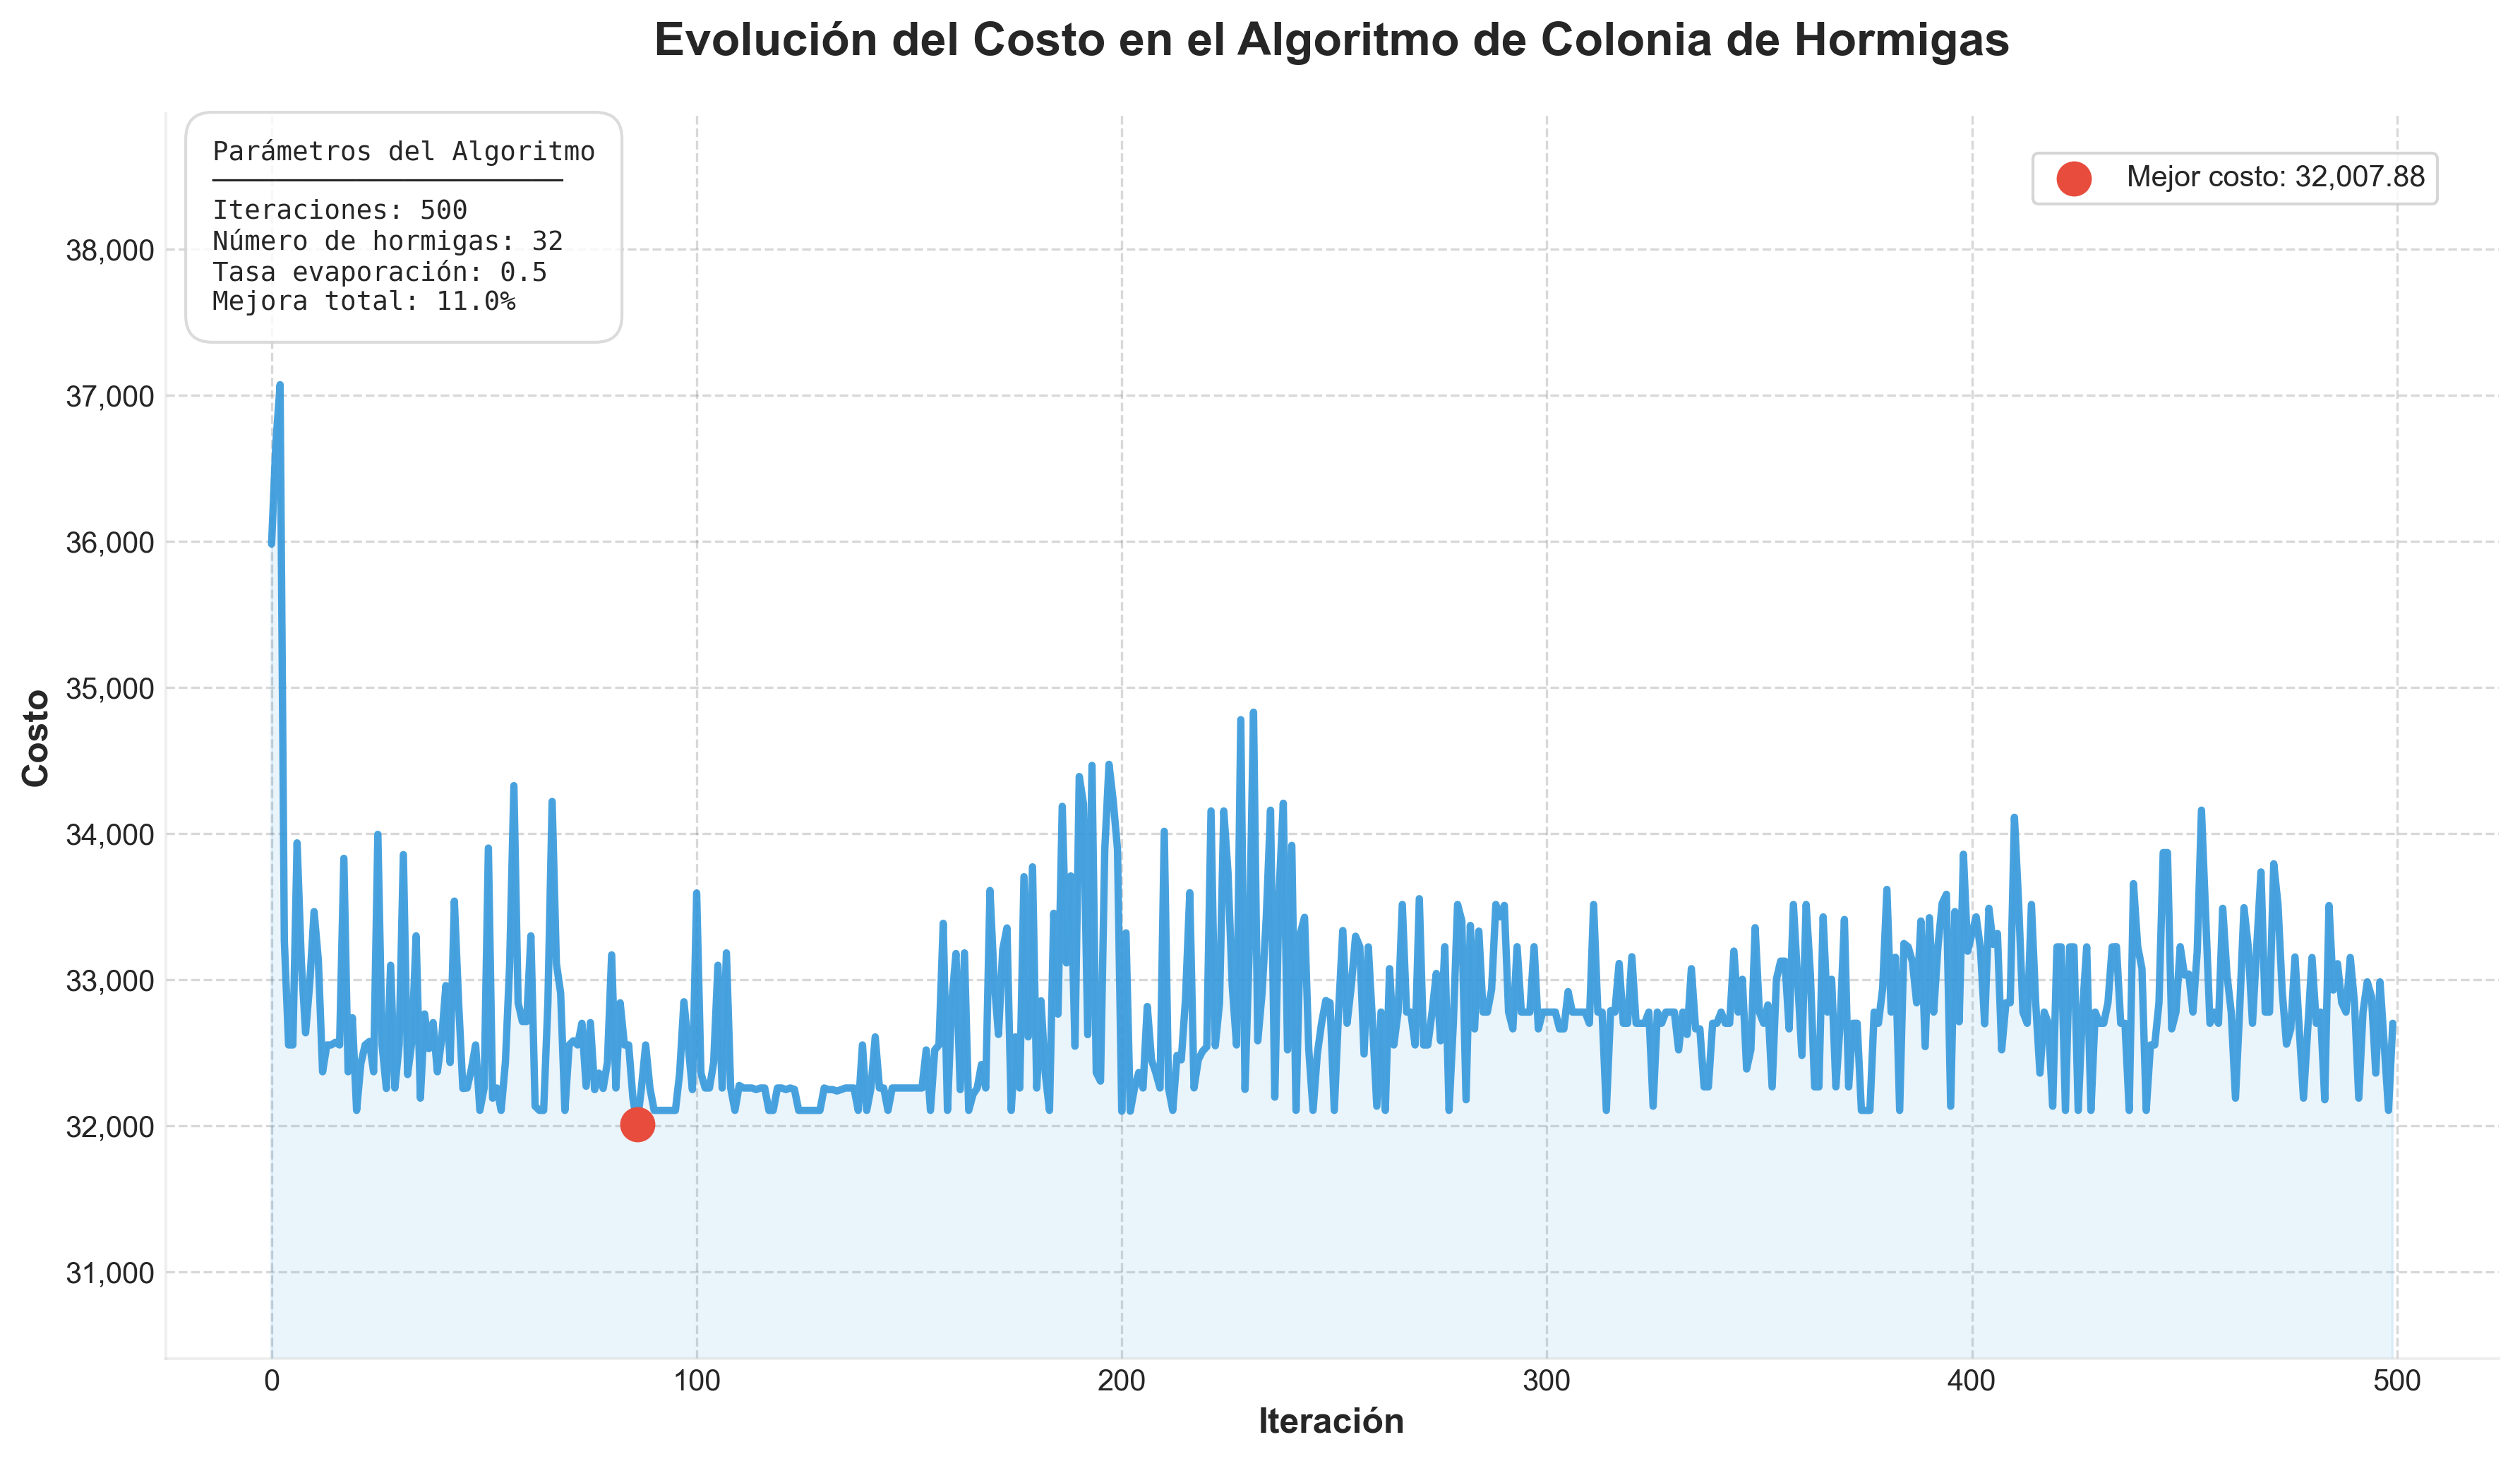

In [292]:
import matplotlib.pyplot as plt
import numpy as np

def plot_aco_evolution(historial_costos, mejor_costo, iteraciones, num_hormigas, tasa_evaporacion):
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear figura con fondo blanco
    fig, ax = plt.subplots(figsize=(12, 7), dpi=300, facecolor='white')
    ax.set_facecolor('white')
    
    # Procesar datos para la gráfica
    # Ahora usamos el mejor costo de cada iteración en lugar del promedio
    mejores_costos_iter = [min(costos) for costos in historial_costos]
    iterations = np.arange(len(mejores_costos_iter))
    
    # Crear el gráfico principal
    main_color = '#3498db'
    ax.plot(iterations, mejores_costos_iter, 
            color=main_color, 
            linewidth=2.5,
            alpha=0.9)
    
    # Añadir área sombreada bajo la curva
    ax.fill_between(iterations, 
                   mejores_costos_iter, 
                   color=main_color, 
                   alpha=0.1)
    
    # Encontrar la iteración donde se encontró el mejor costo
    idx_mejor_costo = mejores_costos_iter.index(mejor_costo)
    
    # Marcar el mejor costo
    ax.scatter(idx_mejor_costo, 
              mejor_costo,
              color='#e74c3c', 
              s=120, 
              zorder=5,
              label=f'Mejor costo: {mejor_costo:,.2f}')
    
    # Personalizar el grid
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Configurar los ejes
    ax.set_xlabel('Iteración', fontsize=12, fontweight='bold')
    ax.set_ylabel('Costo', fontsize=12, fontweight='bold')
    
    # Eliminar los bordes del gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.3)
    
    # Formatear los números del eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Ajustar los límites del eje Y
    ymin = min(mejores_costos_iter) * 0.95
    ymax = max(mejores_costos_iter) * 1.05
    ax.set_ylim(ymin, ymax)
    
    # Título principal
    plt.title('Evolución del Costo en el Algoritmo de Colonia de Hormigas', 
             fontsize=16, 
             fontweight='bold', 
             pad=20)
    
    # Crear cuadro de texto para los parámetros
    mejora_total = ((mejores_costos_iter[0] - mejor_costo) / mejores_costos_iter[0] * 100)
    param_text = (
        'Parámetros del Algoritmo\n'
        '──────────────────────\n'
        f'Iteraciones: {iteraciones}\n'
        f'Número de hormigas: {num_hormigas}\n'
        f'Tasa evaporación: {tasa_evaporacion}\n'
        f'Mejora total: {mejora_total:.1f}%'
    )
    
    # Añadir el cuadro de texto
    plt.text(0.02, 0.98, param_text,
             transform=ax.transAxes,
             fontsize=9,
             fontfamily='monospace',
             bbox=dict(facecolor='white',
                      edgecolor='lightgray',
                      alpha=0.8,
                      pad=10,
                      boxstyle='round,pad=1'),
             verticalalignment='top')
    
    # Leyenda
    legend = ax.legend(frameon=True,
                      framealpha=0.9,
                      fontsize=10,
                      loc='upper right',
                      bbox_to_anchor=(0.98, 0.98))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.8)
    
    # Ajustar los márgenes
    plt.tight_layout()
    
    # Guardar con alta calidad
    plt.savefig('evolucion_costos_aco.png',
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    
    plt.show()

# Para usar la función:
plot_aco_evolution(
    historial_costos,
    mejor_costo,
    ITERACIONES,
    NUM_HORMIGAS,
    EVAPORACION
)

In [293]:
def crear_mapa_ruta(mejor_ruta_ciudades, coordenadas):
    """
    Crea un mapa interactivo con la ruta optimizada entre ciudades.
    
    Args:
        mejor_ruta_ciudades (list): Lista de ciudades en orden de visita
        coordenadas (dict): Diccionario con las coordenadas de cada ciudad
    """
    # Crear un mapa centrado en México con estilo más limpio
    mapa = folium.Map(location=[23.6345, -102.5528], 
                     zoom_start=5,
                     tiles='cartodbpositron')
    
    # Crear una lista de coordenadas en el orden de la ruta
    coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta_ciudades]
    
    
    # Añadir marcadores para cada ciudad
    for i, ciudad in enumerate(mejor_ruta_ciudades):
        # Color especial para inicio y fin
        if i == 0:
            color = 'green'
            prefijo = 'Inicio: '
            icon = 'play'
        elif i == len(mejor_ruta_ciudades) - 1:
            color = 'red'
            prefijo = 'Fin: '
            icon = 'flag'
        else:
            color = 'blue'
            prefijo = f'Parada {i}: '
            icon = 'info-sign'
            
        folium.Marker(
            coordenadas[ciudad],
            popup=f"{prefijo}{ciudad}",
            tooltip=f"{i+1}. {ciudad}",
            icon=folium.Icon(color=color, icon=icon)
        ).add_to(mapa)
    
    # Dibujar las líneas entre las ciudades
    coordenadas_ruta.append(coordenadas_ruta[0])  # Conectar con el punto inicial
    folium.PolyLine(
        coordenadas_ruta,
        weight=2.5,
        color='#1E90FF',
        opacity=0.8,
        popup='Ruta optimizada'
    ).add_to(mapa)
    
    # Añadir una leyenda mejorada con información de distancia
    leyenda_html = f'''
        <div style="position: fixed; 
                    bottom: 50px; 
                    left: 50px; 
                    background-color: white; 
                    padding: 10px; 
                    border: 1px solid grey;
                    border-radius: 5px;
                    box-shadow: 3px 3px 3px rgba(0,0,0,0.2);
                    z-index: 1000;">
            <div style="font-size: 14px; font-weight: bold; margin-bottom: 10px;">
                Ruta Optimizada
            </div>
            <p><i class="fa fa-play" style="color:green"></i> Inicio</p>
            <p><i class="fa fa-info-sign" style="color:blue"></i> Paradas</p>
            <p><i class="fa fa-flag" style="color:red"></i> Fin</p>
        </div>
    '''
    mapa.get_root().html.add_child(folium.Element(leyenda_html))
    
    # Añadir elementos adicionales al mapa
    folium.LayerControl().add_to(mapa)
    plugins.MiniMap().add_to(mapa)
    plugins.MousePosition().add_to(mapa)
    
    # Guardar el mapa
    mapa.save('ruta_encontrada_ferry.html')
    print(f"\n💾 Mapa guardado como 'ruta_encontrada_ferry.html'")
    
    return mapa

mapa_ruta = crear_mapa_ruta(mejor_ruta_ciudades, coordenadas)


💾 Mapa guardado como 'ruta_encontrada_ferry.html'


In [294]:
import folium
from folium import plugins
import openrouteservice as ors
import time

def visualizar_ruta(mejor_ruta_ciudades):
    """
    Visualiza la ruta optimizada entre las ciudades usando OpenRouteService.
    
    Args:
        mejor_ruta_ciudades (list): Lista de nombres de ciudades en el orden optimizado
    """
    # Limpiar los nombres de las ciudades
    ciudades = [ciudad.strip() for ciudad in mejor_ruta_ciudades]
    
    # API key de OpenRouteService
    api_key = "5b3ce3597851110001cf6248c140bc578aac4c2d95295dc798e53a22"
    
    # Crear cliente de OpenRouteService
    client = ors.Client(key=api_key)
    
    # Geocodificar las ciudades para obtener coordenadas
    coordenadas = []
    for ciudad in ciudades:
        try:
            # Añadir ", México" para mejorar la precisión de la búsqueda
            geocode = client.pelias_search(text=f"{ciudad}, México")
            coords = geocode['features'][0]['geometry']['coordinates']
            coordenadas.append(coords)
            print(f"✓ Coordenadas encontradas para {ciudad}")
            # Añadir pequeña pausa para evitar límites de la API
            time.sleep(1)
        except Exception as e:
            print(f"✗ Error al geocodificar {ciudad}: {e}")
            continue
    
    # Crear mapa centrado en México
    mapa = folium.Map(location=[23.6345, -102.5528], 
                     zoom_start=5,
                     tiles='cartodbpositron')
    
    # Añadir marcadores para cada ciudad
    for i, coords in enumerate(coordenadas):
        # Color específico según la posición
        if i == 0:
            color = 'green'
            prefix = 'Inicio: '
            icon = 'play'
        elif i == len(coordenadas) - 1:
            color = 'red'
            prefix = 'Fin: '
            icon = 'flag'
        else:
            color = 'blue'
            prefix = f'Parada {i}: '
            icon = 'info-sign'
            
        folium.Marker(
            [coords[1], coords[0]],
            popup=prefix + ciudades[i],
            tooltip=f"{i+1}. {ciudades[i]}",
            icon=folium.Icon(color=color, icon=icon)  # Ahora usamos el icon específico definido
        ).add_to(mapa)
    
    # Obtener y dibujar la ruta entre ciudades consecutivas
    distancia_total = 0
    tiempo_total = 0
    
    # Añadir la última conexión al punto inicial para cerrar el ciclo
    coordenadas.append(coordenadas[0])
    ciudades.append(ciudades[0])
    
    for i in range(len(coordenadas)-1):
        try:
            # Obtener ruta entre par de ciudades
            ruta = client.directions(
                coordinates=[coordenadas[i], coordenadas[i+1]],
                profile='driving-car',
                format='geojson'
            )
            
            # Dibujar la ruta en el mapa
            folium.GeoJson(
                ruta,
                name=f'Ruta {i+1}: {ciudades[i]} - {ciudades[i+1]}',
                style_function=lambda x: {'color': '#1E90FF', 'weight': 2, 'opacity': 0.7}
            ).add_to(mapa)
            
            # Calcular y acumular estadísticas
            distancia = ruta['features'][0]['properties']['segments'][0]['distance']
            duracion = ruta['features'][0]['properties']['segments'][0]['duration']
            distancia_total += distancia
            tiempo_total += duracion
            
            print(f"\n📍 Ruta {i+1}: {ciudades[i]} → {ciudades[i+1]}:")
            print(f"   Distancia: {distancia/1000:.1f} km")
            print(f"   Tiempo estimado: {duracion/3600:.1f} horas")
            
            # Pequeña pausa para respetar límites de la API
            time.sleep(1)
            
        except Exception as e:
            print(f"✗ Error al obtener ruta entre {ciudades[i]} y {ciudades[i+1]}: {e}")
    
    # Imprimir resumen del viaje
    print(f"\n📊 Resumen del viaje:")
    print(f"   Distancia total: {distancia_total/1000:.1f} km")
    print(f"   Tiempo total estimado: {tiempo_total/3600:.1f} horas")
    
    # Añadir elementos adicionales al mapa
    folium.LayerControl().add_to(mapa)
    plugins.MiniMap().add_to(mapa)
    plugins.MousePosition().add_to(mapa)
    
    # Actualizar la leyenda con los iconos correctos
    leyenda_html = '''
        <div style="position: fixed; bottom: 50px; left: 50px; 
                    background-color: white; padding: 10px; border: 1px solid grey;
                    z-index: 1000;">
        <h4>Leyenda</h4>
            <p><i class="fa fa-play" style="color:green"></i> Inicio</p>
            <p><i class="fa fa-info-sign" style="color:blue"></i> Paradas</p>
            <p><i class="fa fa-flag" style="color:red"></i> Fin</p>
        Distancia total: {:.1f} km<br>
        Tiempo estimado: {:.1f} horas</p>
        </div>
    '''.format(distancia_total/1000, tiempo_total/3600)
    
    mapa.get_root().html.add_child(folium.Element(leyenda_html))
    
    # Guardar mapa
    mapa.save('ruta_carreteras_ferry.html')
    print("\n💾 Mapa guardado como 'ruta_carreteras_ferry.html'")

visualizar_ruta(mejor_ruta_ciudades)

✓ Coordenadas encontradas para Mexicali
✓ Coordenadas encontradas para La Paz
✓ Coordenadas encontradas para Culiacán Rosales
✓ Coordenadas encontradas para Tepic
✓ Coordenadas encontradas para Guadalajara
✓ Coordenadas encontradas para Colima
✓ Coordenadas encontradas para Morelia
✓ Coordenadas encontradas para Guanajuato
✓ Coordenadas encontradas para Santiago de Querétaro
✓ Coordenadas encontradas para Toluca de Lerdo
✓ Coordenadas encontradas para CDMX
✓ Coordenadas encontradas para Cuernavaca
✓ Coordenadas encontradas para Chilpancingo de los Bravo
✓ Coordenadas encontradas para Tlaxcala de Xicohténcatl
✓ Coordenadas encontradas para Heroica Puebla de Zaragoza
✓ Coordenadas encontradas para Oaxaca de Juárez
✓ Coordenadas encontradas para Tuxtla Gutiérrez
✓ Coordenadas encontradas para Villahermosa
✓ Coordenadas encontradas para San Francisco de Campeche
✓ Coordenadas encontradas para Mérida
✓ Coordenadas encontradas para Chetumal
✓ Coordenadas encontradas para Xalapa-Enríquez
✓ Co

In [295]:
ciudades = [
    'Chilpancingo, Guerrero',
    'Cuernavaca, Morelos',
    'Ciudad de México, Ciudad de México',
    'Pachuca, Hidalgo',
    'Puebla, Puebla',
    'Tlaxcala, Tlaxcala',
    'Morelia, Michoacán',
    'Querétaro, Querétaro',
    'San Luis Potosí, San Luis Potosí',
    'Guanajuato, Guanajuato',
    'Aguascalientes, Aguascalientes',
    'Zacatecas, Zacatecas',
    'Durango, Durango',
    'Culiacán, Sinaloa',
    'Hermosillo, Sonora',
    'Mexicali, Baja California',
    'Colima, Colima',
    'Guadalajara, Jalisco',
    'Tepic, Nayarit',
    'Chihuahua, Chihuahua',
    'Monterrey, Nuevo León',
    'Ciudad Victoria, Tamaulipas',
    'Saltillo, Coahuila',
    'Oaxaca de Juárez, Oaxaca',
    'Xalapa, Veracruz',
    'Villahermosa, Tabasco',
    'Campeche, Campeche',
    'Mérida, Yucatán',
    'Chetumal, Quintana Roo',
    'Tuxtla Gutiérrez, Chiapas',
    'Toluca, Estado de México'
]

In [296]:
np.random.seed(42)

In [297]:
distancias = pd.read_csv("tabla_distancias.csv", index_col=0)  # Tabla de distancias (km)
tiempos = pd.read_csv("tabla_tiempos.csv", index_col=0)        # Tabla de tiempos (horas)
peajes = pd.read_csv("peajes.csv", index_col=0)  # Tabla de costos de peajes (MXN)

# Eliminar la fila y columna llamada "La Paz"
distancias = distancias.drop(index="La Paz", columns="La Paz")
tiempos = tiempos.drop(index="La Paz", columns="La Paz")
peajes = peajes.drop(index="La Paz", columns="La Paz")


In [298]:
def convertir_a_minutos(tiempo):
    if pd.isna(tiempo):
        return np.nan
    horas, minutos = map(int, str(tiempo).split(':'))
    return horas * 60 + minutos

tiempos_minutos = tiempos.map(convertir_a_minutos)

print("Tiempos convertidos a minutos satisfactoriamente.")

Tiempos convertidos a minutos satisfactoriamente.


In [299]:
num_ciudades = distancias.shape[0]
costos = np.zeros((num_ciudades, num_ciudades))

for i in range(num_ciudades):
    for j in range(num_ciudades):
        if i != j:  # Evitar costos para una ciudad hacia sí misma
            distancia = distancias.iloc[i, j]
            tiempo = tiempos_minutos.iloc[i, j] / 60
            peaje = peajes.iloc[i, j]

            costo_combustible = (distancia / RENDIMIENTO_AUTO) * COSTO_COMBUSTIBLE
            costo_tiempo = tiempo * VALOR_HORA

            costos[i, j] = costo_combustible + costo_tiempo + peaje

matriz_costos = pd.DataFrame(costos, index=distancias.index, columns=distancias.columns)

matriz_costos.to_excel("matriz_costos.xlsx")

print("Matriz de costos calculada y guardada en 'matriz_costos.xlsx'")

Matriz de costos calculada y guardada en 'matriz_costos.xlsx'


In [300]:
matriz_costos = pd.read_excel("matriz_costos.xlsx", index_col=0)
ciudades = matriz_costos.index

In [301]:
NUM_HORMIGAS = 31
ALFA = 1  
BETA = 2  
EVAPORACION = 0.5
ITERACIONES = 500
Q = 100 

In [302]:
num_ciudades = len(ciudades)
feromonas = np.ones((num_ciudades, num_ciudades))
mejor_ruta = None
mejor_costo = float("inf")

In [303]:
np.random.seed(42)

historial_costos = []
historial_mejor_costo = []

for _ in range(ITERACIONES):
    soluciones = []
    costos_iteracion = []
    for _ in range(NUM_HORMIGAS):
        ruta = construir_ruta()
        costo = calcular_costo(ruta)
        soluciones.append((ruta, costo))
        costos_iteracion.append(costo)
        
        if costo < mejor_costo:
            mejor_ruta, mejor_costo = ruta, costo
    
    historial_costos.append(costos_iteracion)
    historial_mejor_costo.append(mejor_costo)

    actualizar_feromonas(soluciones)

mejor_ruta_ciudades = [ciudades[i] for i in mejor_ruta]
print("Mejor ruta encontrada:", mejor_ruta_ciudades)
print("Costo total:", mejor_costo)

Mejor ruta encontrada: ['Saltillo', 'Monterrey', 'Ciudad Victoria', 'San Luis Potosí', 'Guanajuato', 'Santiago de Querétaro', 'Toluca de Lerdo', 'CDMX', 'Cuernavaca', 'Chilpancingo de los Bravo', 'Pachuca de Soto', 'Tlaxcala de Xicohténcatl', 'Heroica Puebla de Zaragoza', 'Oaxaca de Juárez', 'Tuxtla Gutiérrez', 'Villahermosa', 'San Francisco de Campeche', 'Mérida', 'Chetumal', 'Xalapa-Enríquez', 'Morelia', 'Guadalajara', 'Colima', 'Tepic', 'Culiacán Rosales', 'Hermosillo', 'Mexicali', 'Chihuahua', 'Victoria de Durango', 'Zacatecas', 'Aguascalientes']
Costo total: 31130.620744320924


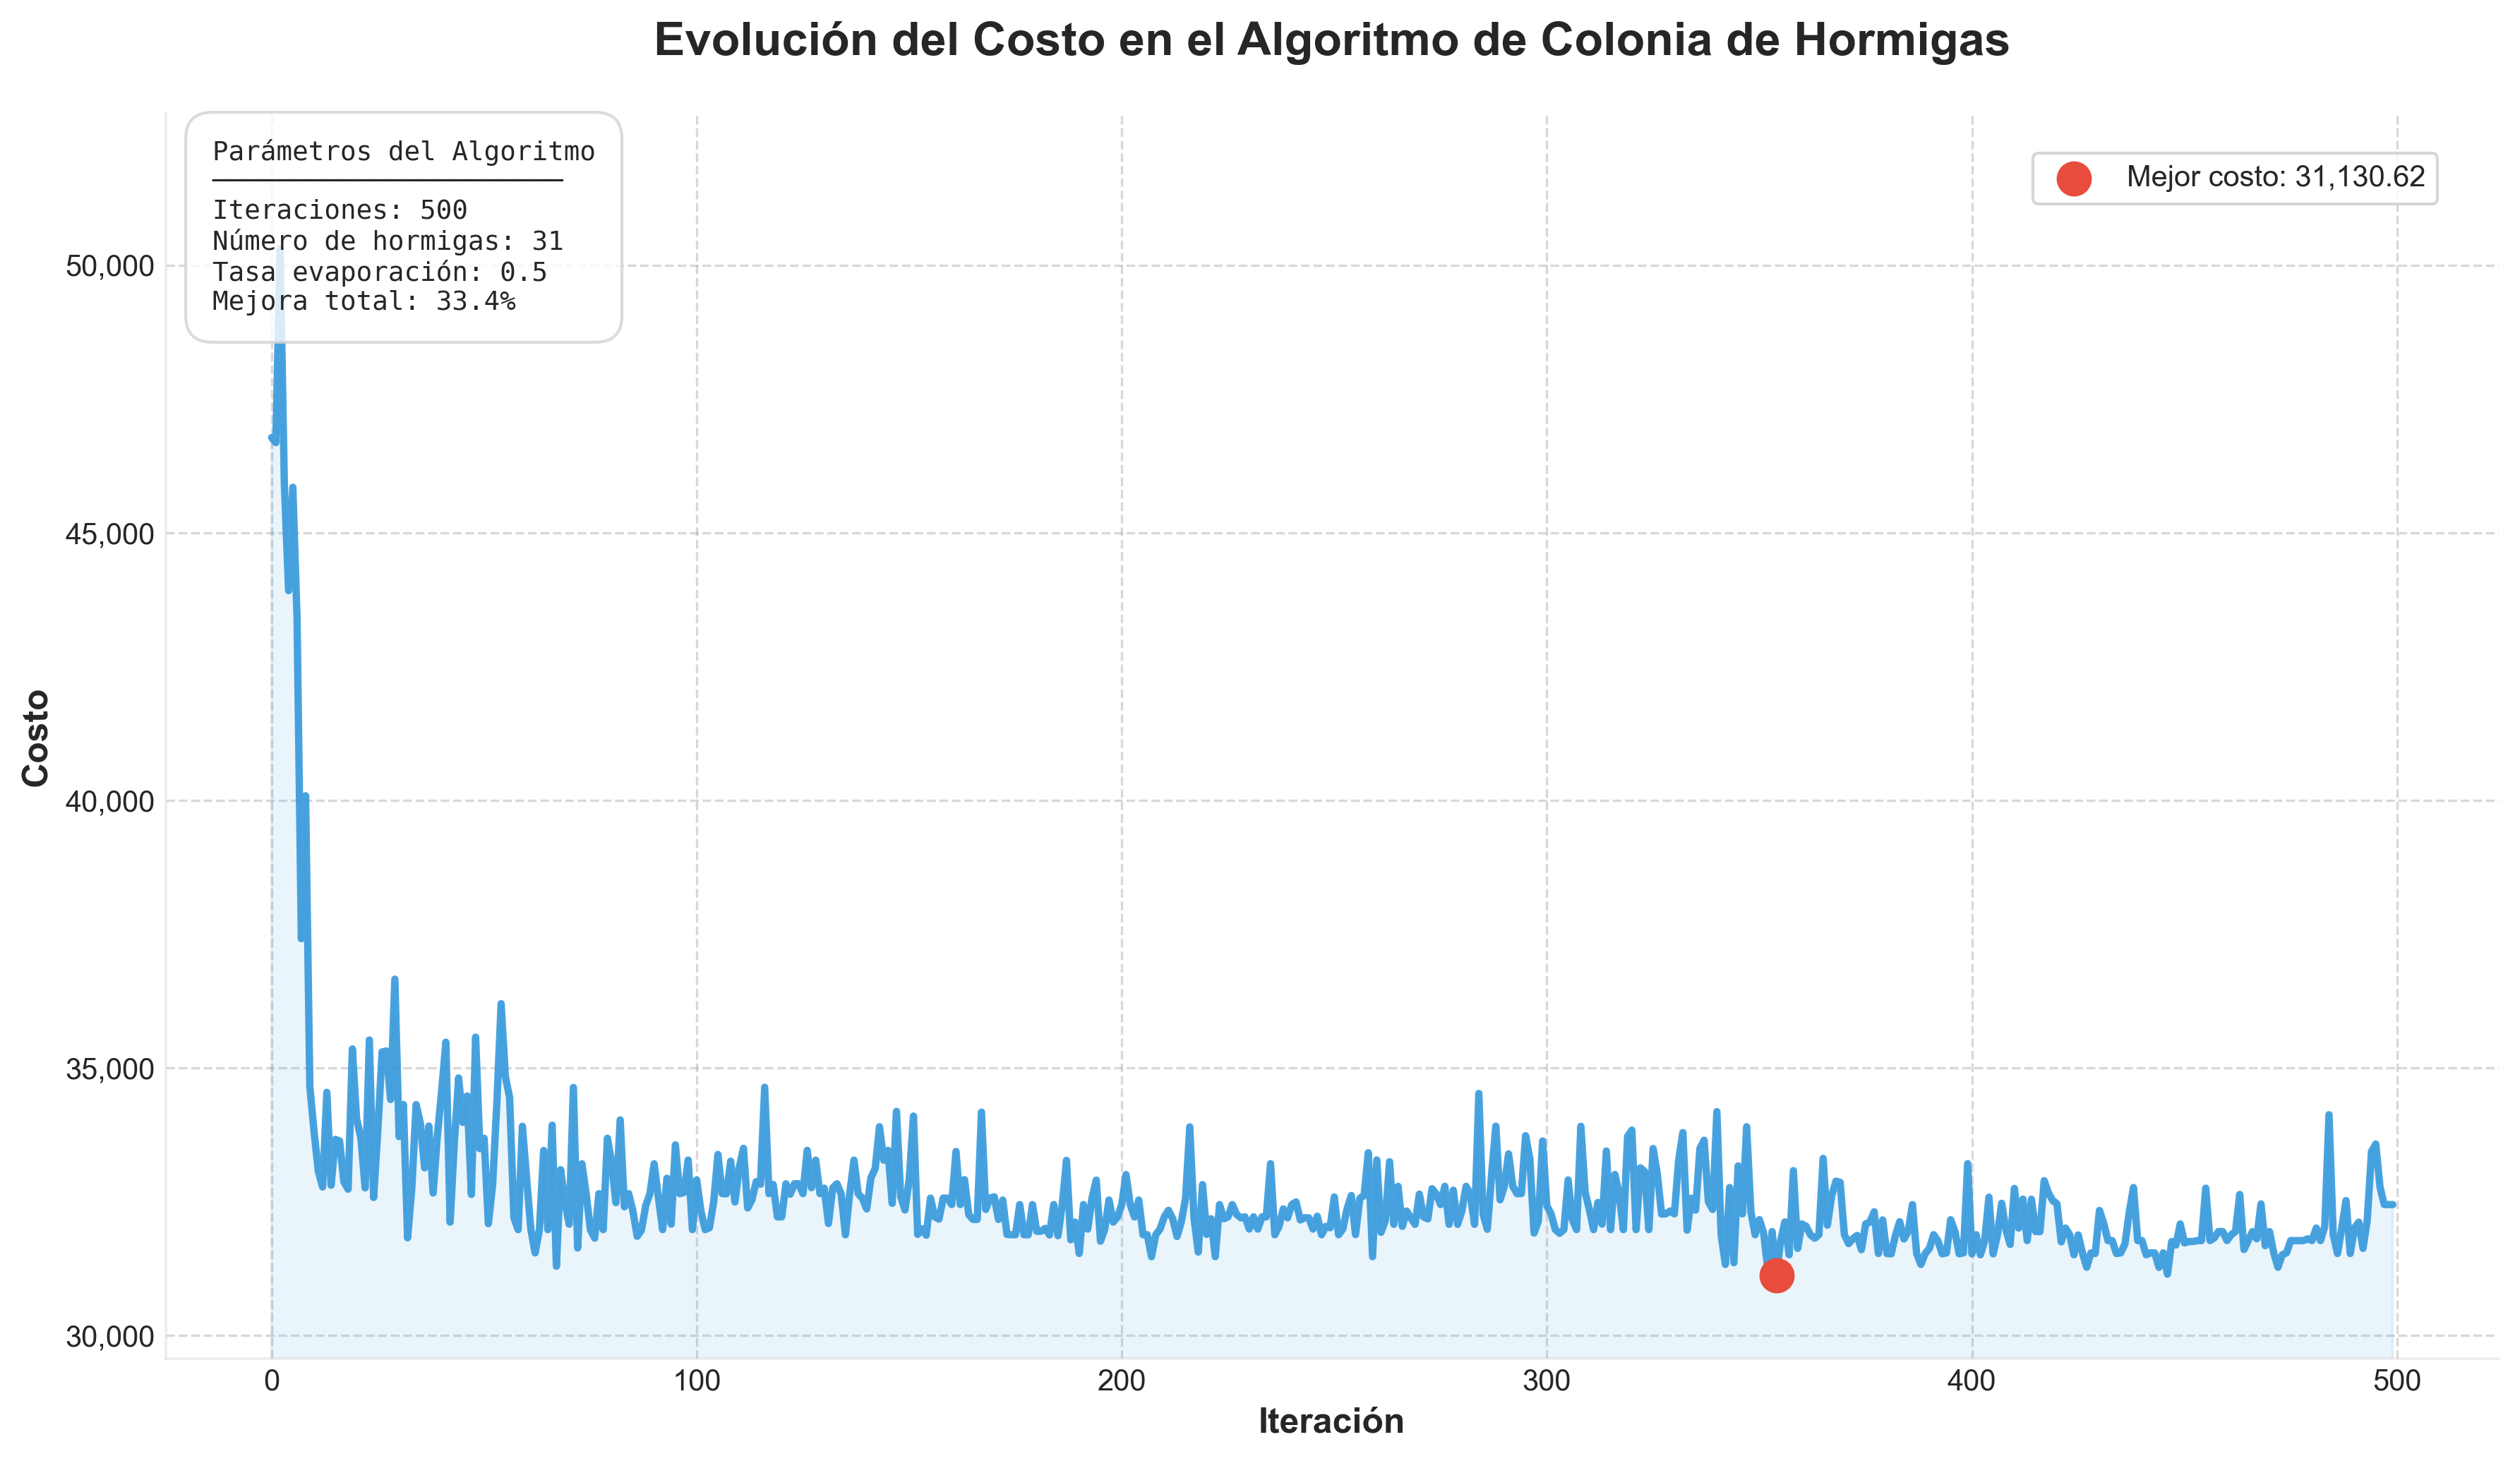

In [304]:
import matplotlib.pyplot as plt
import numpy as np

def plot_aco_evolution(historial_costos, mejor_costo, iteraciones, num_hormigas, tasa_evaporacion):
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear figura con fondo blanco
    fig, ax = plt.subplots(figsize=(12, 7), dpi=300, facecolor='white')
    ax.set_facecolor('white')
    
    # Procesar datos para la gráfica
    # Ahora usamos el mejor costo de cada iteración en lugar del promedio
    mejores_costos_iter = [min(costos) for costos in historial_costos]
    iterations = np.arange(len(mejores_costos_iter))
    
    # Crear el gráfico principal
    main_color = '#3498db'
    ax.plot(iterations, mejores_costos_iter, 
            color=main_color, 
            linewidth=2.5,
            alpha=0.9)
    
    # Añadir área sombreada bajo la curva
    ax.fill_between(iterations, 
                   mejores_costos_iter, 
                   color=main_color, 
                   alpha=0.1)
    
    # Encontrar la iteración donde se encontró el mejor costo
    idx_mejor_costo = mejores_costos_iter.index(mejor_costo)
    
    # Marcar el mejor costo
    ax.scatter(idx_mejor_costo, 
              mejor_costo,
              color='#e74c3c', 
              s=120, 
              zorder=5,
              label=f'Mejor costo: {mejor_costo:,.2f}')
    
    # Personalizar el grid
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Configurar los ejes
    ax.set_xlabel('Iteración', fontsize=12, fontweight='bold')
    ax.set_ylabel('Costo', fontsize=12, fontweight='bold')
    
    # Eliminar los bordes del gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.3)
    
    # Formatear los números del eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Ajustar los límites del eje Y
    ymin = min(mejores_costos_iter) * 0.95
    ymax = max(mejores_costos_iter) * 1.05
    ax.set_ylim(ymin, ymax)
    
    # Título principal
    plt.title('Evolución del Costo en el Algoritmo de Colonia de Hormigas', 
             fontsize=16, 
             fontweight='bold', 
             pad=20)
    
    # Crear cuadro de texto para los parámetros
    mejora_total = ((mejores_costos_iter[0] - mejor_costo) / mejores_costos_iter[0] * 100)
    param_text = (
        'Parámetros del Algoritmo\n'
        '──────────────────────\n'
        f'Iteraciones: {iteraciones}\n'
        f'Número de hormigas: {num_hormigas}\n'
        f'Tasa evaporación: {tasa_evaporacion}\n'
        f'Mejora total: {mejora_total:.1f}%'
    )
    
    # Añadir el cuadro de texto
    plt.text(0.02, 0.98, param_text,
             transform=ax.transAxes,
             fontsize=9,
             fontfamily='monospace',
             bbox=dict(facecolor='white',
                      edgecolor='lightgray',
                      alpha=0.8,
                      pad=10,
                      boxstyle='round,pad=1'),
             verticalalignment='top')
    
    # Leyenda
    legend = ax.legend(frameon=True,
                      framealpha=0.9,
                      fontsize=10,
                      loc='upper right',
                      bbox_to_anchor=(0.98, 0.98))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.8)
    
    # Ajustar los márgenes
    plt.tight_layout()
    
    # Guardar con alta calidad
    plt.savefig('evolucion_costos_aco.png',
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    
    plt.show()

# Para usar la función:
plot_aco_evolution(
    historial_costos,
    mejor_costo,
    ITERACIONES,
    NUM_HORMIGAS,
    EVAPORACION
)

In [305]:
def crear_mapa_ruta(mejor_ruta_ciudades, coordenadas):
    """
    Crea un mapa interactivo con la ruta optimizada entre ciudades.
    
    Args:
        mejor_ruta_ciudades (list): Lista de ciudades en orden de visita
        coordenadas (dict): Diccionario con las coordenadas de cada ciudad
    """
    # Crear un mapa centrado en México con estilo más limpio
    mapa = folium.Map(location=[23.6345, -102.5528], 
                     zoom_start=5,
                     tiles='cartodbpositron')
    
    # Crear una lista de coordenadas en el orden de la ruta
    coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta_ciudades]
    
    
    # Añadir marcadores para cada ciudad
    for i, ciudad in enumerate(mejor_ruta_ciudades):
        # Color especial para inicio y fin
        if i == 0:
            color = 'green'
            prefijo = 'Inicio: '
            icon = 'play'
        elif i == len(mejor_ruta_ciudades) - 1:
            color = 'red'
            prefijo = 'Fin: '
            icon = 'flag'
        else:
            color = 'blue'
            prefijo = f'Parada {i}: '
            icon = 'info-sign'
            
        folium.Marker(
            coordenadas[ciudad],
            popup=f"{prefijo}{ciudad}",
            tooltip=f"{i+1}. {ciudad}",
            icon=folium.Icon(color=color, icon=icon)
        ).add_to(mapa)
    
    # Dibujar las líneas entre las ciudades
    coordenadas_ruta.append(coordenadas_ruta[0])  # Conectar con el punto inicial
    folium.PolyLine(
        coordenadas_ruta,
        weight=2.5,
        color='#1E90FF',
        opacity=0.8,
        popup='Ruta optimizada'
    ).add_to(mapa)
    
    # Añadir una leyenda mejorada con información de distancia
    leyenda_html = f'''
        <div style="position: fixed; 
                    bottom: 50px; 
                    left: 50px; 
                    background-color: white; 
                    padding: 10px; 
                    border: 1px solid grey;
                    border-radius: 5px;
                    box-shadow: 3px 3px 3px rgba(0,0,0,0.2);
                    z-index: 1000;">
            <div style="font-size: 14px; font-weight: bold; margin-bottom: 10px;">
                Ruta Optimizada
            </div>
            <p><i class="fa fa-play" style="color:green"></i> Inicio</p>
            <p><i class="fa fa-info-sign" style="color:blue"></i> Paradas</p>
            <p><i class="fa fa-flag" style="color:red"></i> Fin</p>
        </div>
    '''
    mapa.get_root().html.add_child(folium.Element(leyenda_html))
    
    # Añadir elementos adicionales al mapa
    folium.LayerControl().add_to(mapa)
    plugins.MiniMap().add_to(mapa)
    plugins.MousePosition().add_to(mapa)
    
    # Guardar el mapa
    mapa.save('ruta_encontrada_31.html')
    print(f"\n💾 Mapa guardado como 'ruta_encontrada_31.html'")
    
    return mapa

mapa_ruta = crear_mapa_ruta(mejor_ruta_ciudades, coordenadas)


💾 Mapa guardado como 'ruta_encontrada_31.html'


In [306]:
import folium
from folium import plugins
import openrouteservice as ors
import time

def visualizar_ruta(mejor_ruta_ciudades):
    """
    Visualiza la ruta optimizada entre las ciudades usando OpenRouteService.
    
    Args:
        mejor_ruta_ciudades (list): Lista de nombres de ciudades en el orden optimizado
    """
    # Limpiar los nombres de las ciudades
    ciudades = [ciudad.strip() for ciudad in mejor_ruta_ciudades]
    
    # API key de OpenRouteService
    api_key = "5b3ce3597851110001cf6248c140bc578aac4c2d95295dc798e53a22"
    
    # Crear cliente de OpenRouteService
    client = ors.Client(key=api_key)
    
    # Geocodificar las ciudades para obtener coordenadas
    coordenadas = []
    for ciudad in ciudades:
        try:
            # Añadir ", México" para mejorar la precisión de la búsqueda
            geocode = client.pelias_search(text=f"{ciudad}, México")
            coords = geocode['features'][0]['geometry']['coordinates']
            coordenadas.append(coords)
            print(f"✓ Coordenadas encontradas para {ciudad}")
            # Añadir pequeña pausa para evitar límites de la API
            time.sleep(1)
        except Exception as e:
            print(f"✗ Error al geocodificar {ciudad}: {e}")
            continue
    
    # Crear mapa centrado en México
    mapa = folium.Map(location=[23.6345, -102.5528], 
                     zoom_start=5,
                     tiles='cartodbpositron')
    
    # Añadir marcadores para cada ciudad
    for i, coords in enumerate(coordenadas):
        # Color específico según la posición
        if i == 0:
            color = 'green'
            prefix = 'Inicio: '
            icon = 'play'
        elif i == len(coordenadas) - 1:
            color = 'red'
            prefix = 'Fin: '
            icon = 'flag'
        else:
            color = 'blue'
            prefix = f'Parada {i}: '
            icon = 'info-sign'
            
        folium.Marker(
            [coords[1], coords[0]],
            popup=prefix + ciudades[i],
            tooltip=f"{i+1}. {ciudades[i]}",
            icon=folium.Icon(color=color, icon=icon)  # Ahora usamos el icon específico definido
        ).add_to(mapa)
    
    # Obtener y dibujar la ruta entre ciudades consecutivas
    distancia_total = 0
    tiempo_total = 0
    
    # Añadir la última conexión al punto inicial para cerrar el ciclo
    coordenadas.append(coordenadas[0])
    ciudades.append(ciudades[0])
    
    for i in range(len(coordenadas)-1):
        try:
            # Obtener ruta entre par de ciudades
            ruta = client.directions(
                coordinates=[coordenadas[i], coordenadas[i+1]],
                profile='driving-car',
                format='geojson'
            )
            
            # Dibujar la ruta en el mapa
            folium.GeoJson(
                ruta,
                name=f'Ruta {i+1}: {ciudades[i]} - {ciudades[i+1]}',
                style_function=lambda x: {'color': '#1E90FF', 'weight': 2, 'opacity': 0.7}
            ).add_to(mapa)
            
            # Calcular y acumular estadísticas
            distancia = ruta['features'][0]['properties']['segments'][0]['distance']
            duracion = ruta['features'][0]['properties']['segments'][0]['duration']
            distancia_total += distancia
            tiempo_total += duracion
            
            print(f"\n📍 Ruta {i+1}: {ciudades[i]} → {ciudades[i+1]}:")
            print(f"   Distancia: {distancia/1000:.1f} km")
            print(f"   Tiempo estimado: {duracion/3600:.1f} horas")
            
            # Pequeña pausa para respetar límites de la API
            time.sleep(1)
            
        except Exception as e:
            print(f"✗ Error al obtener ruta entre {ciudades[i]} y {ciudades[i+1]}: {e}")
    
    # Imprimir resumen del viaje
    print(f"\n📊 Resumen del viaje:")
    print(f"   Distancia total: {distancia_total/1000:.1f} km")
    print(f"   Tiempo total estimado: {tiempo_total/3600:.1f} horas")
    
    # Añadir elementos adicionales al mapa
    folium.LayerControl().add_to(mapa)
    plugins.MiniMap().add_to(mapa)
    plugins.MousePosition().add_to(mapa)
    
    # Actualizar la leyenda con los iconos correctos
    leyenda_html = '''
        <div style="position: fixed; bottom: 50px; left: 50px; 
                    background-color: white; padding: 10px; border: 1px solid grey;
                    z-index: 1000;">
        <h4>Leyenda</h4>
            <p><i class="fa fa-play" style="color:green"></i> Inicio</p>
            <p><i class="fa fa-info-sign" style="color:blue"></i> Paradas</p>
            <p><i class="fa fa-flag" style="color:red"></i> Fin</p>
        Distancia total: {:.1f} km<br>
        Tiempo estimado: {:.1f} horas</p>
        </div>
    '''.format(distancia_total/1000, tiempo_total/3600)
    
    mapa.get_root().html.add_child(folium.Element(leyenda_html))
    
    # Guardar mapa
    mapa.save('ruta_carreteras_31.html')
    print("\n💾 Mapa guardado como 'ruta_carreteras_31.html'")

visualizar_ruta(mejor_ruta_ciudades)

✓ Coordenadas encontradas para Saltillo
✓ Coordenadas encontradas para Monterrey
✓ Coordenadas encontradas para Ciudad Victoria
✓ Coordenadas encontradas para San Luis Potosí
✓ Coordenadas encontradas para Guanajuato
✓ Coordenadas encontradas para Santiago de Querétaro
✓ Coordenadas encontradas para Toluca de Lerdo
✓ Coordenadas encontradas para CDMX
✓ Coordenadas encontradas para Cuernavaca
✓ Coordenadas encontradas para Chilpancingo de los Bravo
✓ Coordenadas encontradas para Pachuca de Soto
✓ Coordenadas encontradas para Tlaxcala de Xicohténcatl
✓ Coordenadas encontradas para Heroica Puebla de Zaragoza
✓ Coordenadas encontradas para Oaxaca de Juárez
✓ Coordenadas encontradas para Tuxtla Gutiérrez
✓ Coordenadas encontradas para Villahermosa
✓ Coordenadas encontradas para San Francisco de Campeche
✓ Coordenadas encontradas para Mérida
✓ Coordenadas encontradas para Chetumal
✓ Coordenadas encontradas para Xalapa-Enríquez
✓ Coordenadas encontradas para Morelia
✓ Coordenadas encontradas 